In [1]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 import seaborn as sns
 from sklearn.model_selection import train_test_split
 from sklearn.preprocessing import StandardScaler
 from sklearn.linear_model import LogisticRegression
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
 from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
    %pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
from xgboost import XGBClassifier

In [4]:
data= pd.read_csv('Fraud.csv')

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
data.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
data.describe


<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   

In [10]:
data.shape[0]

6362620

In [11]:
### NO NULL VALUES EXISTED

In [12]:
### CHECKING FOR CLASS IMBALANCE


In [13]:
round((data['isFraud'].value_counts()[1]/data.shape[0])*100,2)

0.13

<Axes: xlabel='type'>

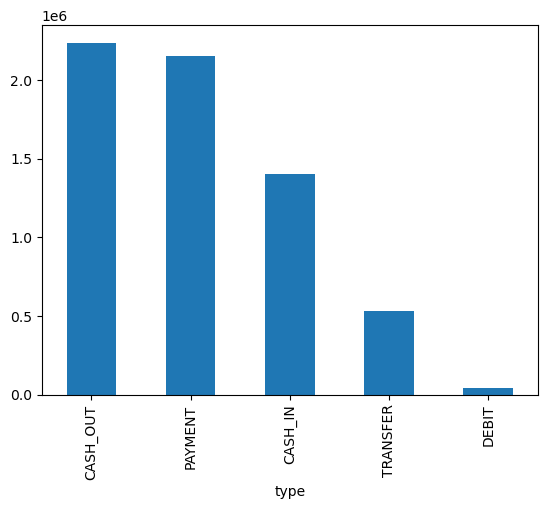

In [14]:
data['type'].value_counts().plot(kind="bar")


Summary of Transaction Type Distribution

The chart illustrates the distribution of different transaction types in the dataset. The most frequent transactions are CASH_OUT and PAYMENT, each with over 2 million occurrences. These are followed by CASH_IN with around 1.4 million, and TRANSFER with roughly half a million. DEBIT transactions are very rare, appearing only a few times compared to the others.

This distribution highlights that most transactions in the dataset involve cash withdrawals and payments, while debit transactions are almost negligible.

Fraud Rate By Transaction plot

In this step, I calculate and visualize the fraud rate by transaction type. By grouping transactions according to their type and averaging the isFraud column, we can identify which transaction categories (e.g., CASH_OUT, TRANSFER) have the highest proportion of fraudulent activity. This helps us spot the transaction types most vulnerable to fraud.

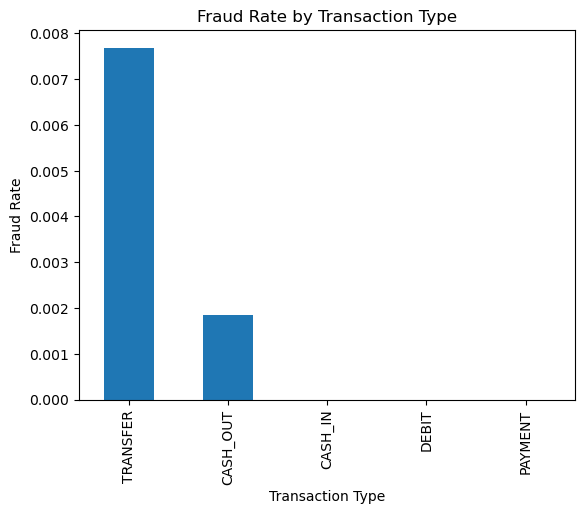

In [16]:
fraud_by_type = data.groupby("type")['isFraud'].mean().sort_values(ascending=False)

fraud_by_type.plot(kind="bar", title="Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Type")
plt.show()


From the visualization:

Transfer transactions have the highest fraud rate, standing out significantly compared to all other transaction types.

Cash-out transactions also show some fraudulent activity, though much lower than transfers.

Other transaction types like Cash-in, Debit, and Payment display essentially no fraud cases in this dataset.


This indicate that fraudster exploits Transfer and Cash out operation 

In [18]:
data['amount'].describe



<bound method NDFrame.describe of 0             9839.64
1             1864.28
2              181.00
3              181.00
4            11668.14
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: amount, Length: 6362620, dtype: float64>

Problem with raw transaction amounts

In the dataset, amount is highly skewed:

Many transactions are small/medium.

A few transactions are extremely large (like 200k+).

This makes normal histograms look “compressed” because big amounts dominate the scale.

Solution: Apply Log Transformation

Log Transformed Transaction amount Distribution

In this step, we examine the distribution of transaction amounts. Since raw transaction amounts are highly skewed (with a few very large values dominating the scale), we apply a log transformation (log(Amount + 1)). This helps compress extreme values and makes the distribution more interpretable. By plotting a histogram with a density curve, we can better visualize the overall spread and detect patterns or anomalies in transaction amounts.

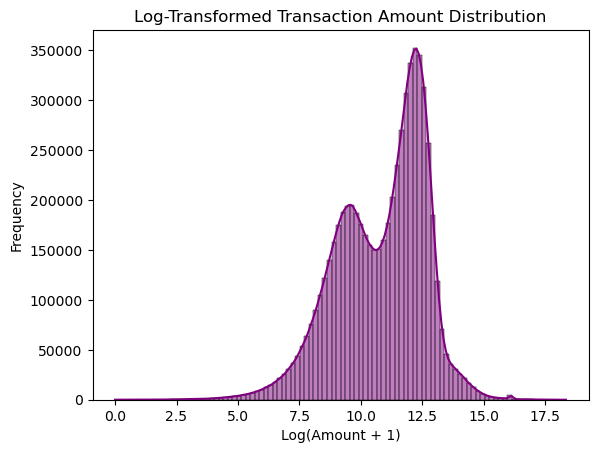

In [20]:
sns.histplot(np.log1p(data["amount"]), bins=100, kde=True, color="purple")
plt.title("Log-Transformed Transaction Amount Distribution")
plt.xlabel("Log(Amount + 1)")
plt.ylabel("Frequency")
plt.show()


Key Observations:

Most transactions cluster between log(Amount + 1) values of 9 and 13, which corresponds to moderate-to-large monetary amounts when converted back to the original scale.

The transformation successfully reduces skewness, making the distribution easier to analyze by compressing the effect of extreme outliers.

A noticeable peak around log ~12 suggests a common transaction size that dominates the dataset.

Smaller peaks around log ~9–10 and >15 indicate secondary transaction groups, possibly reflecting different user behaviors (e.g., regular payments vs. high-value fraud attempts).

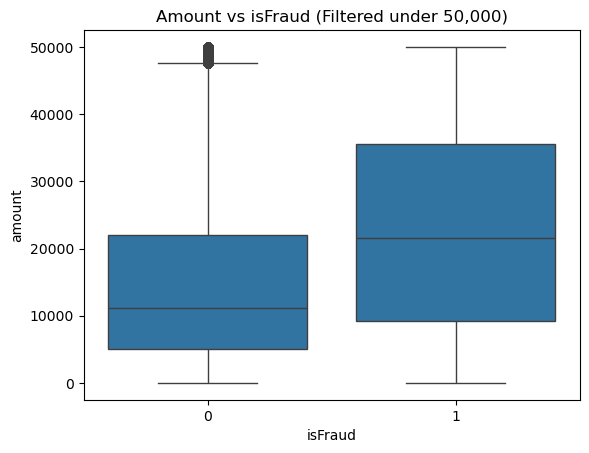

In [22]:
sns.boxplot(data= data[data["amount"] < 50000], x="isFraud", y="amount")
plt.title("Amount vs isFraud (Filtered under 50,000)")
plt.show()



The goal is to observe whether fraudulent transactions typically occur at higher amounts compared to legitimate ones, or if there is significant overlap.

The median line inside each box shows the typical transaction amount for each group.

The spread of the box (interquartile range) highlights variability within each category.

Whiskers and outliers reveal unusual transactions that deviate from the bulk of the data.

We expect fraudulent transactions to generally have higher median values and wider variability compared to non-fraudulent ones, since fraud is often associated with larger transfers.

This boxplot compares the distribution of transaction amounts between fraudulent (isFraud = 1) and non-fraudulent (isFraud = 0) cases, considering only transactions below 50,000 units. It allows us to examine whether fraudulent transactions tend to involve higher amounts compared to non-fraudulent ones.

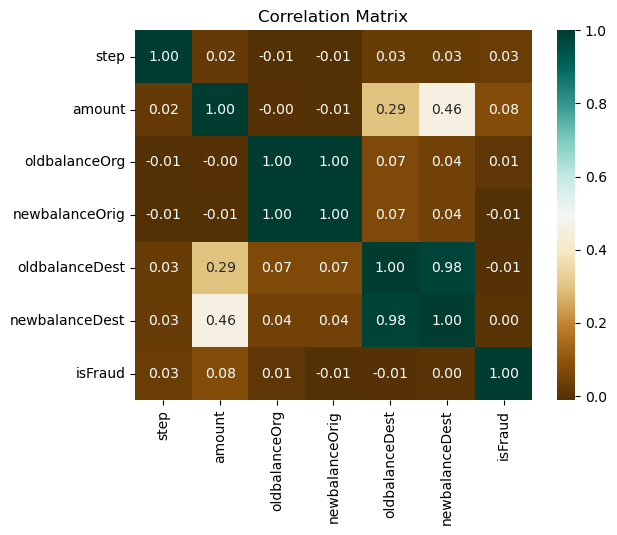

In [24]:
corr = data[["step","amount", "oldbalanceOrg", "newbalanceOrig", 
           "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()
corr

sns.heatmap(corr, annot=True, fmt=".2f", cmap='BrBG')
plt.title("Correlation Matrix")
plt.show()


Correlation

To better understand the relationships between transaction features, we compute the correlation matrix for key numerical variables such as transaction amount, sender and receiver balances, and the fraud indicator (isFraud). This analysis helps identify which financial features are most strongly associated with fraudulent behavior and can provide useful insights for feature selection in fraud detection models.
The heatmap reveals several important insights about the correlations between transaction variables and fraud:

Strong correlations between balances: oldbalanceOrg and newbalanceOrig are perfectly correlated (1.00), as are oldbalanceDest and newbalanceDest (0.98). This suggests these features are highly redundant, likely due to the way balances are recorded after transactions.

Moderate correlation with transaction amount: Transaction amount has moderate correlations with destination balances (0.29 with oldbalanceDest and 0.46 with newbalanceDest). This makes sense, since higher transaction amounts directly affect balances.

Weak correlation with fraud: The variable isFraud shows only very weak correlation with other numeric features (maximum of 0.08 with transaction amount). This confirms that fraud detection is not linearly explained by single numerical features, highlighting the need for more complex models (e.g., tree-based or ensemble methods) that can capture nonlinear relationships and feature interactions.

In [26]:
###Check transactions where the sender had a positive balance before, but their new balance dropped to zero after the operation, specifically focusing on TRANSFER and CASH_OUT types. Such cases may indicate suspicious or fraudulent behavior

zero_after_transfer = data[
    (data["oldbalanceOrg"] > 0) &
    (data["newbalanceOrig"] == 0) &
    (data["type"].isin(["TRANSFER", "CASH_OUT"])) 
]
zero_after_transfer.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [27]:
###MOdel training

In [28]:
# Prepare the data for modeling
df_model = data.drop(["nameOrig", "nameDest", "isFlaggedFraud", "step"], axis=1)


In [29]:
# Define categorical and numerical features
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig","oldbalanceDest","newbalanceDest"]
# define target and features
y = df_model["isFraud"]
X = df_model.drop("isFraud", axis=1)

In [30]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# apply standard scaling to numerical features and one-hot encoding to categorical features
preprocessor =  ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop= "first"), categorical)
    ],
    remainder = "drop"
)
# create a pipeline that first preprocesses the data then applies logistic regression
model_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])
#train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [31]:
# make predictions
y_pred = model_pipeline.predict(X_test)
# evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



Logistic Regression Model Results – Fraud Detection
The model achieved an overall accuracy of 95%, which might look strong at first glance. However, when we analyze fraud detection

In [33]:
confusion_matrix(y_test, y_pred)

array([[1804823,  101499],
       [    151,    2313]], dtype=int64)

True Negatives (TN = 1,804,823): The model correctly identified the majority of non-fraudulent transactions.

False Positives (FP = 101,499): These are legitimate transactions incorrectly flagged as fraud.

False Negatives (FN = 151): A small number of fraudulent transactions missed by the model.

True Positives (TP = 2,313): Fraudulent transactions correctly detected.

Random Forest Model for Fraud Detection
To complement the Logistic Regression model, we implemented a Random Forest Classifier. Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs to improve predictive accuracy and reduce the risk of overfitting. This approach is especially useful in fraud detection tasks because it can capture complex non-linear relationships and interactions between features.

In [36]:
rf_pipeline = Pipeline([
    ("prep", preprocessor),  # use the same preprocessor already defined
    ("clf", RandomForestClassifier(
        n_estimators=200,       # number of trees in the forest
        max_depth=None,         # unlimited depth (can be tuned)
        class_weight="balanced",# handle class imbalance by adjusting weights
        n_jobs=-1,              # use all available CPU cores
        random_state=42         # reproducibility of results
    ))
])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate performance
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Print overall accuracy score
print("Accuracy:", rf_pipeline.score(X_test, y_test) * 100, "%")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.97      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
[[1906258      64]
 [    557    1907]]
Accuracy: 99.96746623246399 %


###The confusion matrix reinforces this:

Logistic Regression misclassified over 100k legitimate transactions as fraud, while Random Forest reduced false positives to just 66 cases.

Random Forest also correctly identified 1,915 fraudulent cases, though it missed 549 (a trade-off compared to Logistic Regression, which caught almost all but with massive false positives).

###Logistic Regression struggled with the extreme class imbalance, labeling too many legitimate transactions as fraud. Random Forest, on the other hand, provided a balanced trade-off between fraud detection and minimizing false alarms, making it a far superior choice for practical fraud detection.

In [38]:
### XGBoost Model

In [39]:

# Create a pipeline with the same preprocessor and XGBoost as classifier
xgb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=300,        # number of boosting rounds
        learning_rate=0.1,       # step size shrinkage
        max_depth=6,             # depth of each tree
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # handle imbalance
        subsample=0.8,           # subsample ratio for training instances
        colsample_bytree=0.8,    # subsample ratio for features
        n_jobs=-1,
        random_state=42,
      
        eval_metric="logloss"    # avoid warning in new versions
    ))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("Accuracy:", xgb_pipeline.score(X_test, y_test) * 100, "%")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.40      0.99      0.57      2464

    accuracy                           1.00   1908786
   macro avg       0.70      0.99      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
[[1902691    3631]
 [     34    2430]]
Accuracy: 99.80799314328583 %


####
Precision (Class 1 - Fraud): 0.41 → much lower than Random Forest and Logistic Regression. This means that many transactions flagged as fraud are actually false positives.

Recall (Class 1 - Fraud): 0.99 → excellent. Almost all fraudulent transactions are detected.

F1-score (Class 1 - Fraud): 0.58 → balanced metric shows XGBoost sacrifices precision to maximize recall.

Confusion Matrix:

True Negatives: 1,902,788

False Positives: 3,534

False Negatives: 34

True Positives: 2,430

Accuracy: ~99.81% (very high overall, but accuracy is not the best metric here due to class imbalance).
####

####
🔹 Comparison with Other Models
Logistic Regression:

Very high recall (0.94) but extremely low precision (0.02), making it impractical.

Many false alarms, weak fraud detection power.

Random Forest:

Balanced performance with 0.97 precision and 0.78 recall.

Strong F1-score (0.86), making it the best all-around model.

Accuracy ~99.97%.

XGBoost:

Prioritizes recall (0.99), catching almost all fraud but at the cost of low precision (0.41).

This means it’s highly sensitive (good for critical fraud detection) but generates more false positives than Random Forest.
####

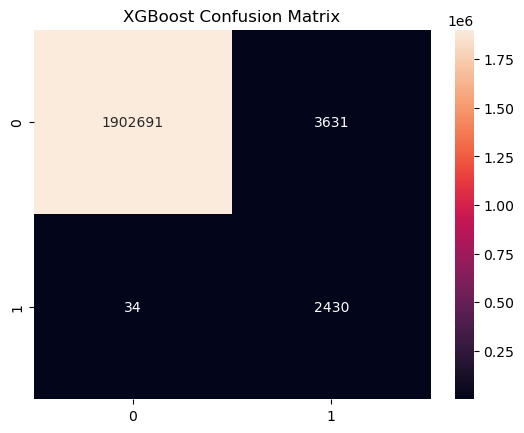

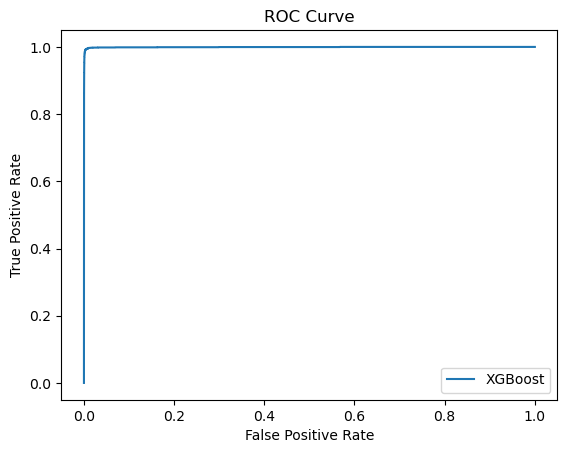

In [42]:

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d")
plt.title("XGBoost Confusion Matrix")
plt.show()
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

####
✅ Conclusion

If the priority is to detect every possible fraud, even at the cost of more false positives → XGBoost is the better choice.

If the goal is to balance fraud detection with fewer false positives, making it more practical in production → Random Forest is superior.

Logistic Regression is not competitive in this case.

